In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [9]:
connect = engine.connect()
measurement_result = pd.read_sql("select * from measurement", connect)
measurement_result


,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [18]:
station_result = pd.read_sql("select * from station", connect)
station_result


,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()


('2017-08-23',)

<AxesSubplot:xlabel='date'>

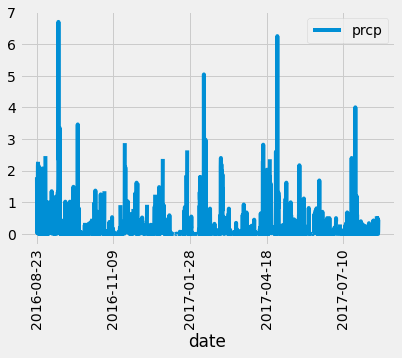

In [36]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date one year from the last date in data set.
one_year = dt.date(2017,8,23) - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]

measurement_year = session.query(*sel)\
                          .filter(Measurement.date>=one_year)\
                          .all()
measurement_year
# Save the query results as a Pandas DataFrame and set the index to the date column
measurement_df = pd.DataFrame(measurement_year, columns =['date', 'prcp'])
measurement_df.set_index('date')

# # Sort the dataframe by date
measurement_df =measurement_df.sort_values('date')

# # Use Pandas Plotting with Matplotlib to plot the data
measurement_df.plot(x='date',y='prcp',rot=90)


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [14]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
engine.execute('select station, COUNT(station) from measurement group by station order by  COUNT(station) desc;').fetchall()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [39]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

print(min_temp)
print(max_temp)
print(avg_temp)

[(54.0,)]
[(85.0,)]
[(71.66378066378067,)]


<AxesSubplot:ylabel='Frequency'>

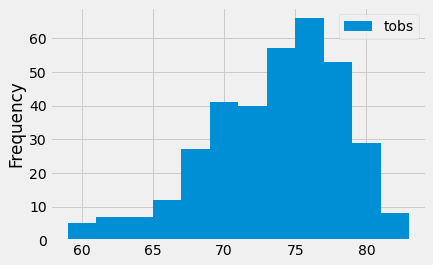

In [43]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).filter(Measurement.date>=one_year).filter(Measurement.station == 'USC00519281').all()
temp_df = pd.DataFrame(results, columns = ['tobs'])
temp_df.plot.hist(bins = 12)

# Close session

In [17]:
# Close Session
session.close()